# LSTM training



In this tutorial, we train a recurrent neural network architecture (i.e., a stack of Bayesian LSTMs) on CDMs data, and use it for prediction purposes.


We assume that data have already been loaded (either from ``.kvn`` format, from pandas ``DataFrame`` object, or from the Kelvins challenge dataset: see the relevant tutorials) and stored into ``events``.

In [16]:
from kessler import EventDataset
path_to_cdms_folder='cdm_data/cdms_kvn/'
events=EventDataset(path_to_cdms_folder)


Loading CDMS (with extension .cdm.kvn.txt) from directory: /Users/giacomoacciarini/cdm_data/cdms_kvn/
Loaded 39 CDMs grouped into 4 events


We can then first define the features that have to be taken into account during training: this is a list of feature names. In this case, we can take all the features present on the uploaded data, provided that they have numeric content:



In [17]:
nn_features=events.common_features(only_numeric=True)

Converting EventDataset to DataFrame
Time spent  | Time remain.| Progress             | Events | Events/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 4/4 | 16.22       


We can then split the data into test (here defined as 5% of the total number of events) and training & validation set:



In [22]:
len_test_set=int(0.5*len(events))
events_test=events[-len_test_set:]
events_train_and_val=events[:-len_test_set]



Finally, we create the LSTM predictor, by defining the LSTM hyperparameters as we wish:

In [23]:
from kessler.nn import LSTMPredictor
model = LSTMPredictor(
           lstm_size=256, #number of hidden units per LSTM layer
           lstm_depth=2,   #number of stacked LSTM layers
           dropout=0.2,   #dropout probability
           features=nn_features) #the list of feature names to use in the LSTM

Then we start the training process:

In [24]:
model.learn(events_train_and_val,
           epochs=1, #number of epochs
           lr=1e-3, #learning rate (can decrease if training diverges)
           batch_size=16, #minibatch size (can decrease if there are memory issues)
           device='cpu', #can be 'cuda' if there is a GPU available
           valid_proportion=0.5, #proportion of data used as validation set
           num_workers=0, #number of multithreaded dataloader workers (usually 4 is good for performances, but if there are issues, try 1)
           event_samples_for_stats=3) #number of events to use to compute NN normalization factors


Converting EventDataset to DataFrame
Time spent  | Time remain.| Progress             | Events | Events/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 2/2 | 1,821.23       


Finally, we save the model to a file after training, and we plot the validation and training loss and save the image to a file:


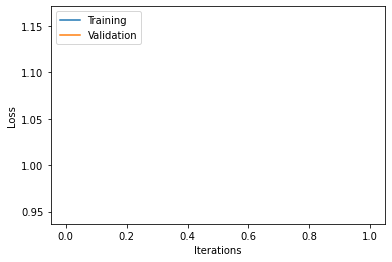

In [25]:
model.save(file_name='LSTM_20epochs_lr1e-4_batchsize16')
model.plot_loss(file_name='plot_loss.pdf')

We now test the prediction. We take a single event, we remove the last CDM and try to predict it:


Predicting event evolution
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:08 | 0d:00:00:00 | #################### | 100/100 | 11.65       


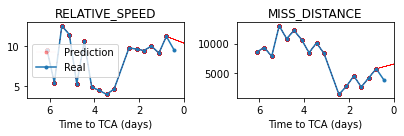

In [27]:
event=events_test[0]
event_len=len(event)
event_beginning=event[0:event_len-1]
event_evolution=model.predict_event(event_beginning, num_samples=100, max_length=14)
#we plot the prediction in red:
axs=event_evolution.plot_features(['RELATIVE_SPEED', 'MISS_DISTANCE'], return_axs=True, linewidth=0.1, color='red', alpha=0.33, label='Prediction')
#and the ground truth value in blue:
event.plot_features(['RELATIVE_SPEED', 'MISS_DISTANCE'], axs=axs, label='Real', legend=True)